In [244]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 5]


In [245]:
tracks_t = uproot.open("../test.root:diffusion output")
#tracks_t.values()

def gauss_2d(coord, means, sig,norm=1):
    x=coord[0]
    y=coord[1]
    return norm*(stats.norm.pdf(x, means[0], sig) * stats.norm.pdf(y,means[1], sig))

def calc_prob(track_dep, z0):
    diff_factor = 0.00323
    z_abs = z0 + 0.72 * 5 * track_dep[2] #0.72 microns/nanosecond
    sigma = diff_factor * np.sqrt(z_abs)
    
    origin = (track_dep[0], track_dep[1])
    charge = track_dep[3]
    
    x = np.arange(origin[0]-10, origin[0]+10, 0.1)#pixels
    y = np.arange(origin[1]-10, origin[1]+10, 0.1) #pixels #1 micron bins
    xx, yy = np.meshgrid(x,y)
    
    vals = gauss_2d((xx,yy), origin, sigma, charge)
    
    return(vals)

def diffuse(track_dep, z0):
    x=[]
    y=[]
    z=[]
    diff_factor = 0.00323
    z_abs = z0 + 0.72 * 5 * track_dep[2] #0.72 microns/nanosecond
    sigma = diff_factor * np.sqrt(z_abs)
    #print(track_dep[3])
    for c in range(int(track_dep[3])):
        x_new = np.random.normal(track_dep[0],sigma)
        y_new = np.random.normal(track_dep[1],sigma)
        x.append(x_new)
        y.append(y_new)
        z.append(z_abs)
    return np.array([x,y,z])

def label_nearby(deps,idx,track_idx):
    #deps is depositions
    #given a track_id, identify all pixels with track_id and then label all pixels touching track_id
    
    found=False
    locs=[]
    for start_pix in deps[np.argwhere(track_idx==idx)]:
        #print(start_pix)
        i_start=start_pix[0][0]
        j_start=start_pix[0][1]
        z_start=start_pix[0][2]
        
        for i, pixel in enumerate(deps):
            
            i_check=pixel[0]
            j_check=pixel[1]
            z_check=pixel[2]
            
            if (not np.isnan(track_idx[i])):
                continue
            #print(start_pix, pixel, diff[i-1])
            #print(np.abs(z_start-z_check))
            if(np.abs(z_start-z_check)<=2):
                dist=np.sqrt((i_check-i_start)**2 + (j_check-j_start)**2)
                if(dist<2):
                    found=True
                    track_idx[i]=idx+1
                    locs.append(i)
    branch_check = deps[np.argwhere(track_idx==idx+1)]
    #print(locs)
    x = branch_check[:,0][:,0]
    y = branch_check[:,0][:,1]
    new_branch=[np.argwhere(track_idx==idx+1)][0]
    if (np.var(x) + np.var(y) >5):
        print('branch found', max(np.diff(x)), max(np.diff(y)))
        max_loc = (np.argwhere(np.diff(y) == max(np.diff(y))))
        #find largest diff in x and y
        y0 = min(y)
        y1 = max(y)
        x0 = min(x)
        x1 = max(x)
        print(y0,y1)
        for i, val in enumerate(branch_check[:,0]):
            if np.abs(val[0]-x0) >=3 or np.abs(val[1]-y0) >=3:
                track_idx[new_branch[i]] = idx+1000
    
            
        
    if (not found):
        #move on with next nan value
        loc=np.min(np.argwhere(np.isnan(track_idx)))
        track_idx[loc] = idx+1
        
        
    return track_idx
def label_track(deps):
    #label all depositions with track ids
    track_idx=np.empty(len(deps))
    track_idx[:]=np.nan
    track_idx[0]=0
    idx=0
    while(np.isnan(np.sum(track_idx))):
        track_idx=label_nearby(deps, idx, track_idx)
       
        #branch check
        
        idx +=1
    return track_idx


def average_track(track_ids, deps, charge):
    avg_pixels=[]
    var=[]
    for pix_id in range(int(max(track_ids)+1)):

        locs = (np.argwhere(track_ids==pix_id))
        if(len(locs)==0):
            continue
        pixels = deps[locs][:,0]
        #print(np.var(pixels[:,0]), np.var(pixels[:,1]))
        x_avg=np.average(pixels[:,0], weights=charge[locs][:,0])
        y_avg=np.average(pixels[:,1], weights=charge[locs][:,0])
        z_avg=np.average(pixels[:,2], weights=charge[locs][:,0])
        charge_sum = np.sum(charge[locs])
        
        avg_pixels.append([x_avg,y_avg,z_avg, charge_sum])
    
    avg_pixels=np.array(avg_pixels)
    
    return avg_pixels

In [252]:
event_num = 5 #good ones: 0,2,6,13,14 sorta:5,10,11 bad: 15(?),18(need to investigate this one),11,4,1,8,9
x_pix = tracks_t["x_pix"].array()[event_num]
y_pix = tracks_t["y_pix"].array()[event_num]
c_dep = tracks_t["depC_pix"].array()[event_num]
z_toa = tracks_t["z_toa"].array()[event_num]
mean_z = tracks_t["mean_z"].array()[event_num]
z_toa = z_toa - min(z_toa)+1
print(np.sum(c_dep))

276657


Method: set start pixel idx to 0, set all touching pixels idx to 1 and repeat
then average numbers


165


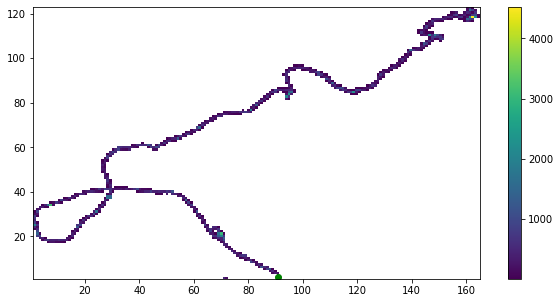

In [253]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (max(x_pix), max(y_pix)), cmin=0.01, weights=c_dep)
#plt.plot(locs[0],locs[1], 'go')
plt.plot(x_pix[0], y_pix[0],'go')
plt.colorbar()
print(len(pix))

In [254]:
pix_array=pix

In [255]:
deps=np.dstack((np.array(x_pix),np.array(y_pix),np.array(z_toa)))[0]
track_idx=np.empty(len(deps))
track_idx[:]=np.nan
track_idx[0]=0
idx=0
track_id=label_track(deps)

branch found 3 2
112 115


In [256]:
avg_track=average_track(track_id, deps, c_dep)

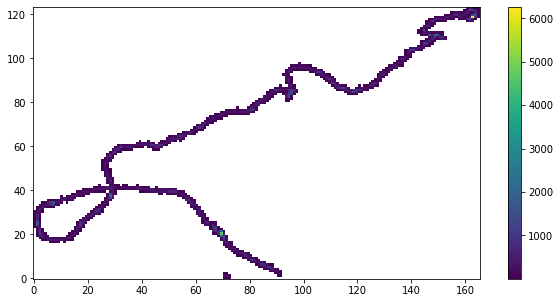

In [257]:
x_new=[]
y_new=[]
#z=[]
for val in avg_track:
    z0=10000#um
    x,y,z=diffuse(val, z0)
    x_new.extend(x)
    y_new.extend(y)
    
    #z.extend(z)
    
pix, xedges, yedges, image = plt.hist2d(x_new, y_new, (max(x_pix), max(y_pix)),cmin=0.1)
plt.colorbar()

    

In [258]:
track_id

array([0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
       3.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 7.000e+00, 8.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 9.000e+00, 1.000e+01, 1.100e+01,
       1.100e+01, 1.200e+01, 1.200e+01, 1.300e+01, 1.300e+01, 1.400e+01,
       1.400e+01, 1.400e+01, 1.500e+01, 1.500e+01, 1.600e+01, 1.600e+01,
       1.700e+01, 1.700e+01, 1.800e+01, 1.800e+01, 1.900e+01, 1.900e+01,
       2.000e+01, 2.000e+01, 2.100e+01, 2.100e+01, 2.100e+01, 2.200e+01,
       2.200e+01, 2.300e+01, 2.300e+01, 2.300e+01, 2.400e+01, 2.400e+01,
       2.400e+01, 2.500e+01, 2.500e+01, 2.500e+01, 2.600e+01, 2.600e+01,
       2.700e+01, 2.700e+01, 2.800e+01, 2.800e+01, 2.900e+01, 2.900e+01,
       3.000e+01, 3.000e+01, 3.100e+01, 3.100e+01, 3.200e+01, 3.200e+01,
       3.300e+01, 3.300e+01, 3.200e+01, 3.400e+01, 3.400e+01, 3.500e+01,
       3.500e+01, 3.600e+01, 3.600e+01, 3.700e+01, 

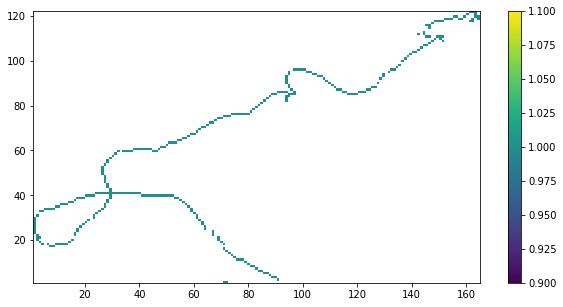

In [259]:
pix, xedges, yedges, image = plt.hist2d(avg_track[:,0], avg_track[:,1], (max(x_pix), max(y_pix)),cmin=0.01)#, weights=avg_track[:,2])
plt.colorbar()

In [260]:
print(avg_track[:,1])

[  2.           3.           3.87240829   4.87779434   5.28732849
   5.81303116   6.14099617   6.8483816    7.32802548   8.0608365
   8.37252312   9.26470588  10.64347826  10.87676056  11.03624382
  11.58372093  12.26144756  13.26734104  14.22298851  15.63577236
  16.4429882   17.92953737  18.9489236   19.95590682  20.88656768
  21.83845339  22.96918267  24.          25.          26.
  27.          28.          29.          30.          31.
  32.          33.          34.          35.          36.
  37.          38.          38.47384615  39.          39.68201618
  40.          39.72327672  40.          39.92886179  39.91788321
  39.97336562  40.          40.00233645  40.10116732  40.17495396
  40.30379747  40.5921659   40.98523622  41.          41.
  41.          41.05693069  41.14720812  41.14971751  41.10791367
  41.06008584  41.          41.          41.          41.
  40.94475138  40.80838323  40.50341686  40.06542056  40.00392927
  40.          39.91695502  39.2375      39.       

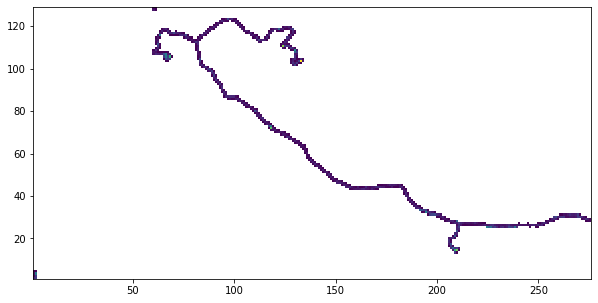

In [241]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (max(x_pix), max(y_pix)), cmin=1, weights=c_dep)


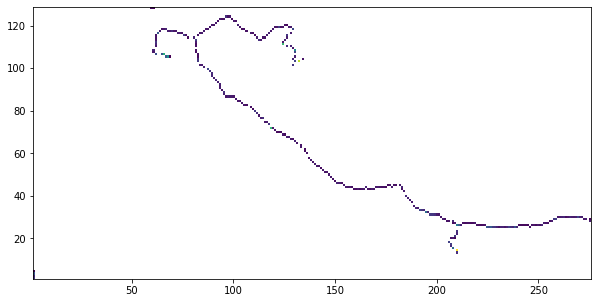

In [242]:
pix, xedges, yedges, image = plt.hist2d(avg_track[:,0], avg_track[:,1], (max(x_pix), max(y_pix)),cmin=0.1, weights=avg_track[:,3])


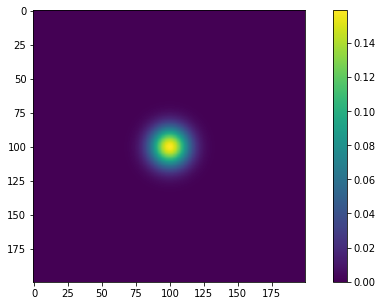

In [243]:
x=np.arange(-10,10,0.1)
y=np.arange(-10,10,0.1)
xx, yy= np.meshgrid(x,y)
pix=np.dstack((xx,yy))
val=gauss_2d((xx,yy), (0,0), 1)
plt.imshow(val)
plt.colorbar()

In [165]:
xx[1]

array([-1.00000000e+01, -9.90000000e+00, -9.80000000e+00, -9.70000000e+00,
       -9.60000000e+00, -9.50000000e+00, -9.40000000e+00, -9.30000000e+00,
       -9.20000000e+00, -9.10000000e+00, -9.00000000e+00, -8.90000000e+00,
       -8.80000000e+00, -8.70000000e+00, -8.60000000e+00, -8.50000000e+00,
       -8.40000000e+00, -8.30000000e+00, -8.20000000e+00, -8.10000000e+00,
       -8.00000000e+00, -7.90000000e+00, -7.80000000e+00, -7.70000000e+00,
       -7.60000000e+00, -7.50000000e+00, -7.40000000e+00, -7.30000000e+00,
       -7.20000000e+00, -7.10000000e+00, -7.00000000e+00, -6.90000000e+00,
       -6.80000000e+00, -6.70000000e+00, -6.60000000e+00, -6.50000000e+00,
       -6.40000000e+00, -6.30000000e+00, -6.20000000e+00, -6.10000000e+00,
       -6.00000000e+00, -5.90000000e+00, -5.80000000e+00, -5.70000000e+00,
       -5.60000000e+00, -5.50000000e+00, -5.40000000e+00, -5.30000000e+00,
       -5.20000000e+00, -5.10000000e+00, -5.00000000e+00, -4.90000000e+00,
       -4.80000000e+00, -

ValueError: too many values to unpack (expected 2)

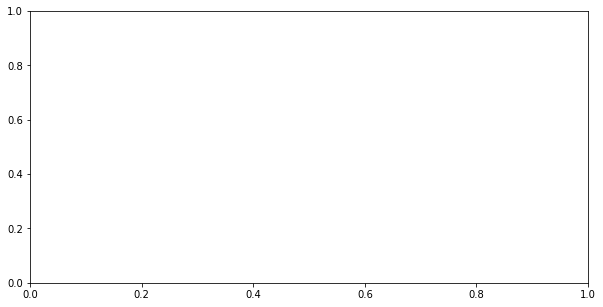

In [166]:
plt.hist2d(xx,yy)

NameError: name 'nan' is not defined